In [33]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from textblob import TextBlob
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from datetime import datetime

In [34]:
# Download required NLTK data
nltk.download('vader_lexicon', quiet=True)
nltk.download('punkt', quiet=True)

True

In [35]:
# Load the dataset
df = pd.read_csv('test.csv')

In [36]:
# Clean date format (handle multiple formats)
def clean_date(date_str):
    try:
        return datetime.strptime(date_str, '%m/%d/%Y')
    except:
        try:
            return datetime.strptime(date_str, '%m/%d/%y')
        except:
            return pd.NaT

df['date'] = df['date'].apply(clean_date)
df = df.dropna(subset=['date'])


In [37]:
# Sentiment analysis function
def analyze_sentiment(text):
    if pd.isna(text) or str(text).strip() == '':
        return 'Neutral', 0
    
    analysis = TextBlob(str(text))
    # Compound score from VADER
    sia = SentimentIntensityAnalyzer()
    vader_score = sia.polarity_scores(str(text))['compound']
    
    # Combine both approaches
    if vader_score >= 0.05:
        return 'Positive', vader_score
    elif vader_score <= -0.05:
        return 'Negative', vader_score
    else:
        return 'Neutral', vader_score

In [39]:
# Apply sentiment analysis
df[['sentiment', 'polarity']] = df['body'].apply(
    lambda x: pd.Series(analyze_sentiment(x))
)

In [40]:
# Extract year-month for time series analysis
df['year_month'] = df['date'].dt.to_period('M')
df['year_month_str'] = df['year_month'].astype(str)

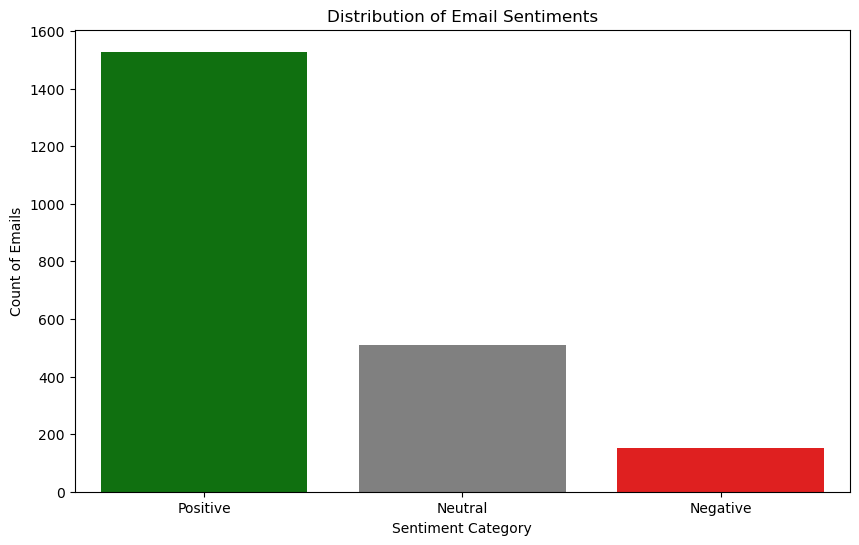

In [41]:
# Visualization 1: Sentiment Distribution
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='sentiment', order=['Positive', 'Neutral', 'Negative'], 
              palette={'Positive':'green', 'Neutral':'gray', 'Negative':'red'})
plt.title('Distribution of Email Sentiments')
plt.xlabel('Sentiment Category')
plt.ylabel('Count of Emails')
plt.show()

C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


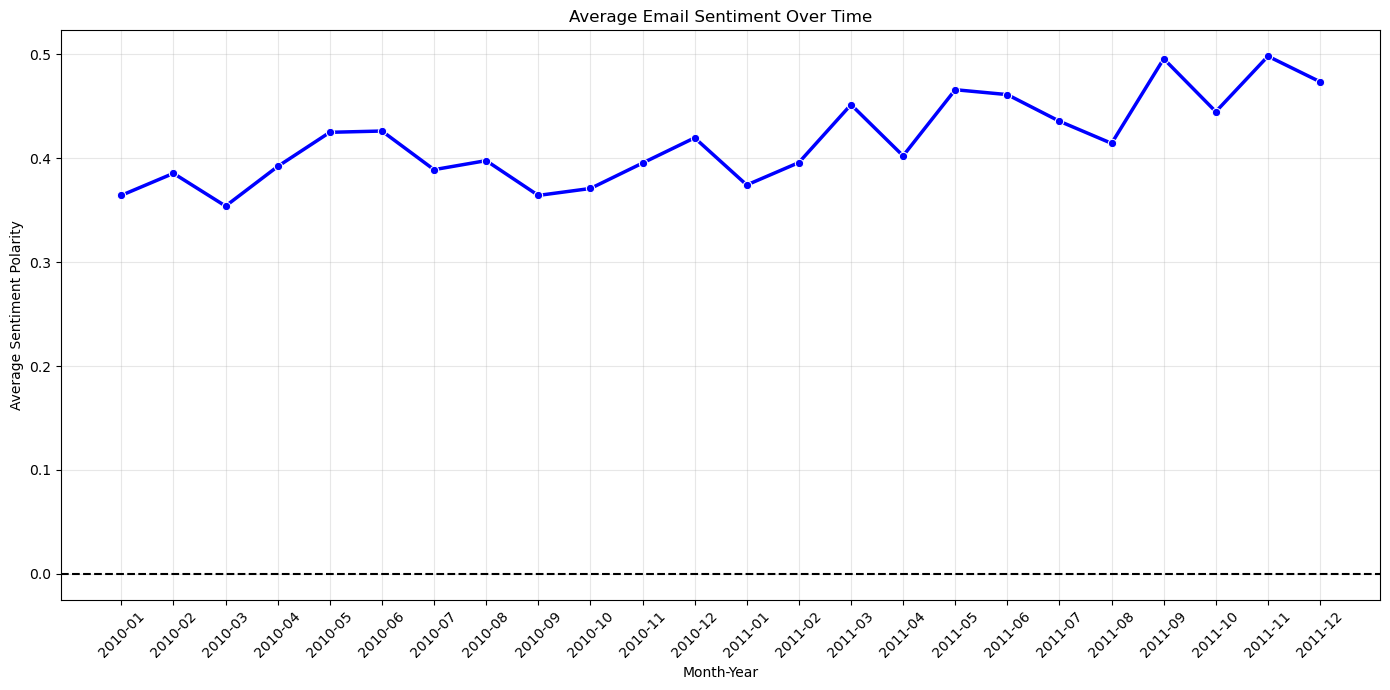

In [42]:
# Visualization 2: Sentiment Over Time
plt.figure(figsize=(14, 7))
monthly_avg = df.groupby('year_month_str')['polarity'].mean().reset_index()

sns.lineplot(data=monthly_avg, x='year_month_str', y='polarity', 
             marker='o', linewidth=2.5, color='blue')
plt.title('Average Email Sentiment Over Time')
plt.xlabel('Month-Year')
plt.ylabel('Average Sentiment Polarity')
plt.xticks(rotation=45)
plt.axhline(0, color='black', linestyle='--')  # Neutral line
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

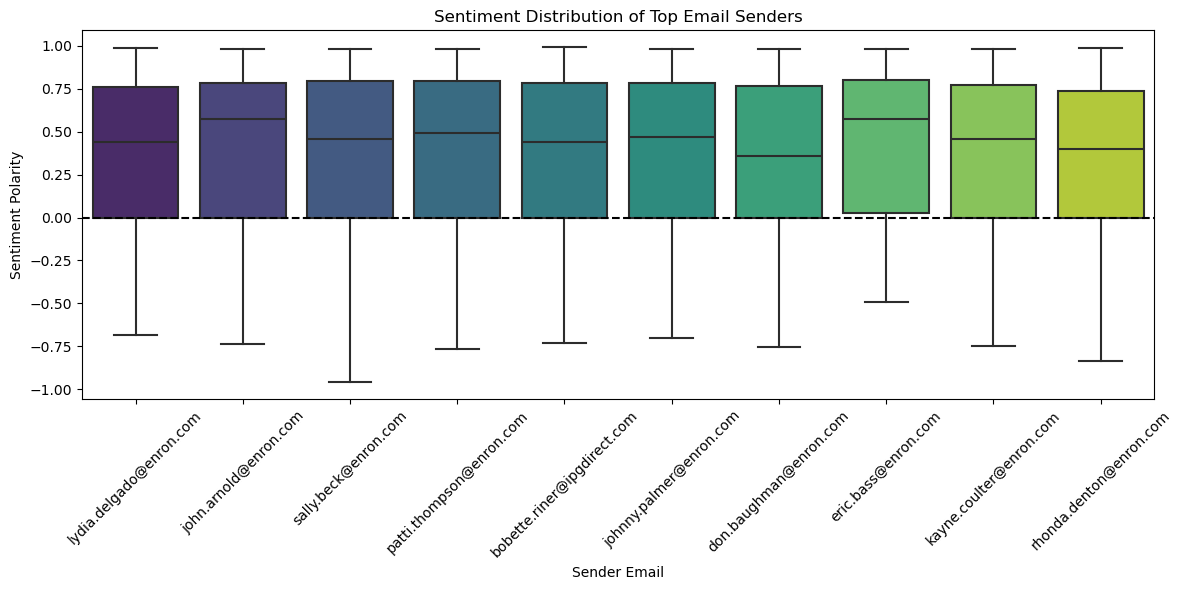

In [43]:
# Visualization 3: Top Senders by Sentiment
top_senders = df['from'].value_counts().head(10).index
df_top = df[df['from'].isin(top_senders)]

plt.figure(figsize=(12, 6))
sns.boxplot(data=df_top, x='from', y='polarity', 
            order=top_senders,
            palette='viridis')
plt.title('Sentiment Distribution of Top Email Senders')
plt.xlabel('Sender Email')
plt.ylabel('Sentiment Polarity')
plt.xticks(rotation=45)
plt.axhline(0, color='black', linestyle='--')
plt.tight_layout()
plt.show()

In [44]:
# Generate some statistics
print("\nEmail Sentiment Statistics:")
print(df['sentiment'].value_counts(normalize=True) * 100)


Email Sentiment Statistics:
sentiment
Positive    69.739845
Neutral     23.322684
Negative     6.937471
Name: proportion, dtype: float64


In [48]:
# Most positive/negative emails
print("\nMost Positive Email:")
print(df.loc[df['polarity'].idxmax(), ['Subject', 'body', 'from']])

print("\nMost Negative Email:")
print(df.loc[df['polarity'].idxmin(), ['Subject', 'body', 'from']])


Most Positive Email:
Subject                           Thanks for January 1, 2000
body       I wanted to extend my thanks in advance to all...
from                             bobette.riner@ipgdirect.com
Name: 2069, dtype: object

Most Negative Email:
Subject                                         Taliban life
body       \nLet's look at  their lifestyle: \nNo premari...
from                                    sally.beck@enron.com
Name: 763, dtype: object
